In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import skimage.io as skio
import skimage.measure as skim
import skimage.transform as skit

import pulse2percept as p2p
import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-15 16:36:56,558 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
subject = '12-005'
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
X, y = p2pspatial.load_data(rootfolder, subject=subject, amplitude=2.0)
electrodes = np.sort(X.electrode.unique())
electrodes

array(['A01', 'A04', 'A06', 'A08', 'A10', 'B01', 'B03', 'B09', 'C04',
       'C07', 'C08', 'C10', 'D01', 'D04', 'D07', 'D08', 'D10', 'E01',
       'E03', 'E07', 'E10', 'F02', 'F04', 'F06', 'F09'], dtype=object)

In [3]:
# Make sure ``combinations`` works as expected
for comb in itertools.combinations(y.iloc[:4, :].iterrows(), 2):
    print(comb[0][0], comb[1][0], p2pspatial.imgproc.dice_loss(comb, n_angles=41))

0 1 0.880222947254
0 2 0.253072778934
0 3 1.18776251346
1 2 0.89123660585
1 3 0.858071602771
2 3 1.21375423072


In [4]:
subjects = ['12-005', '51-009', '52-001']

losses = {}
scales = {}
rotats = {}
dices = {}
labels = {}
for subject in subjects:
    print('Processing %s' % subject)
    loss = []
    scale = []
    rotat = []
    dice = []
    label = []
    for electrode in electrodes:
        X, y = p2pspatial.load_data(rootfolder, subject=subject, 
                                    electrodes=electrode, amplitude=2.0)
        # `return_raw` returns: loss, loss_scale, loss_rot, loss_dice
        ret = p2p.utils.parfor(p2pspatial.imgproc.dice_loss, 
                                itertools.combinations(y.iterrows(), 2), 
                                func_kwargs={'n_angles': 41, 'return_raw': True})
        loss.append([l[0] for l in ret])
        scale.append([s[1] for s in ret])
        rotat.append([r[2] for r in ret])
        dice.append([d[3] for d in ret])
        label.append(electrode)
    losses[subject] = loss
    scales[subject] = scale
    rotats[subject] = rotat
    dices[subject] = dice
    labels[subject] = label

Processing 12-005
Processing 51-009
Processing 52-001


# Total loss
---

`loss = loss_scale + loss_rot + loss_dice`

where each loss term is in [0, 1], so the overal loss is in [0, 3]

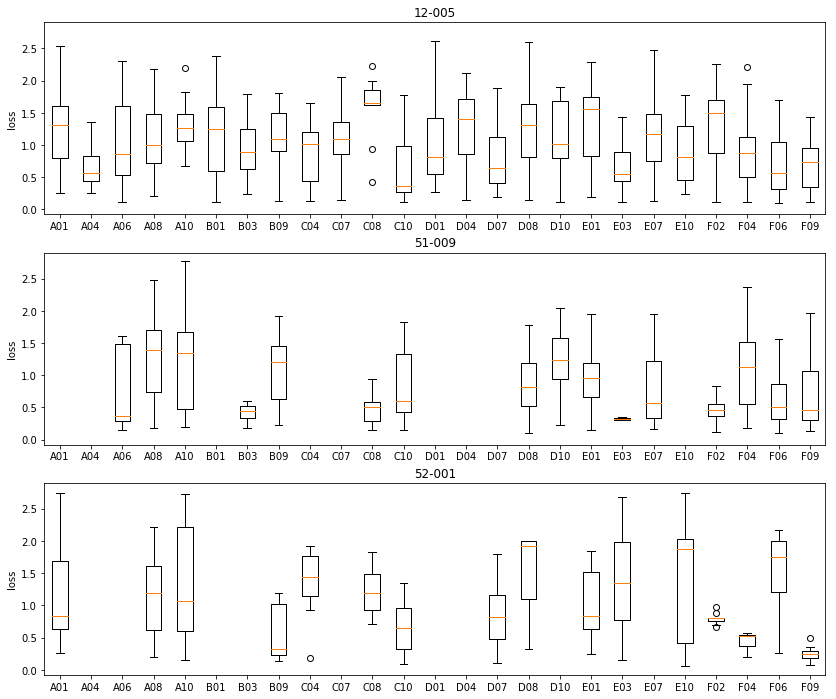

In [6]:
fig, axes = plt.subplots(nrows=len(subjects), sharey=True, figsize=(14, 4 * len(subjects)))

for ax, subject in zip(axes.ravel(), subjects):    
    ax.boxplot(losses[subject], labels=labels[subject], showfliers=True)
    ax.set_ylabel('loss')
    ax.set_title(subject)

# loss_scale
---

Scaling factor:
- symmetric around 1: scaling factors of 0.5 and 2 have the same loss
- scaling factors capped at 10
- loss scaled to [0, 1]

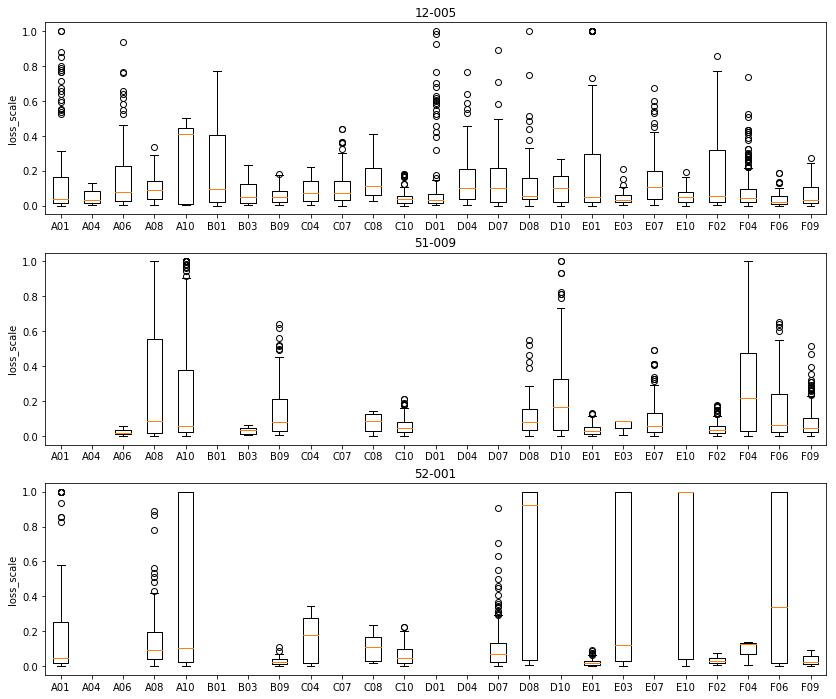

In [7]:
fig, axes = plt.subplots(nrows=len(subjects), sharey=True, figsize=(14, 4 * len(subjects)))

for ax, subject in zip(axes.ravel(), subjects):    
    ax.boxplot(scales[subject], labels=labels[subject], showfliers=True)
    ax.set_ylabel('loss_scale')
    ax.set_title(subject)

# loss_rot
---

Rotation angle:
- symmetric around 0: rotating by +10 deg and -10 deg gives the same loss
- scaled to [0, 1]

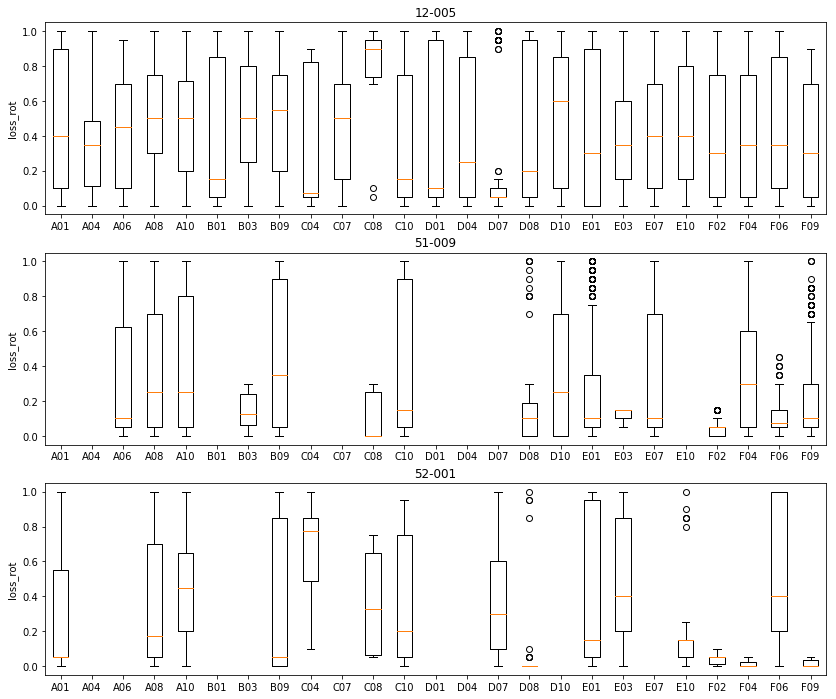

In [8]:
fig, axes = plt.subplots(nrows=len(subjects), sharey=True, figsize=(14, 4 * len(subjects)))

for ax, subject in zip(axes.ravel(), subjects):    
    ax.boxplot(rotats[subject], labels=labels[subject], showfliers=True)
    ax.set_ylabel('loss_rot')
    ax.set_title(subject)

# loss_dice
---

Dice loss:
- 1 - dice coefficient

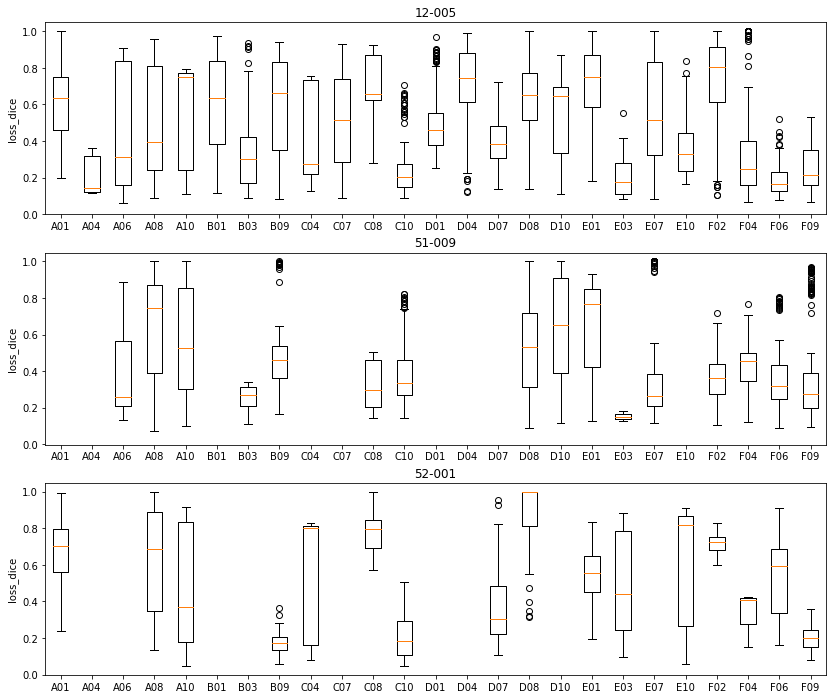

In [10]:
fig, axes = plt.subplots(nrows=len(subjects), sharey=True, figsize=(14, 4 * len(subjects)))

for ax, subject in zip(axes.ravel(), subjects):    
    ax.boxplot(dices[subject], labels=labels[subject], showfliers=True)
    ax.set_ylabel('loss_dice')
    ax.set_title(subject)